In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def load_dataset():
    train_set = pd.read_csv(
        "F:\\SACHIN\\Study\\Projects\\ML_Data\\mnist-digits\\train.csv")
    test_set = pd.read_csv(
        "F:\\SACHIN\\Study\\Projects\\ML_Data\\mnist-digits\\test.csv")

    train_set_x = train_set.drop(columns=['label'])
    train_set_x_orig = np.array(train_set_x)
    train_set_y_orig = np.array(train_set['label'][:])

    test_set_x_orig = np.array(test_set)

    return train_set_x_orig, train_set_y_orig, test_set_x_orig

In [3]:
X_train_orig, y_train_orig, X_test_orig = load_dataset()

print(X_train_orig.shape)
print(y_train_orig.shape)
print(X_test_orig.shape)

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train_orig, y_train_orig, test_size=0.1, random_state=42)

(42000, 784)
(42000,)
(28000, 784)


In [4]:
def convert_to_one_hot(labels, C):
    C = tf.constant(C, name='C')
    one_hot_matrix =tf.one_hot(labels, C, axis=0)

    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()

    return one_hot

In [5]:
y_train = convert_to_one_hot(y_train, 10)

y_dev = convert_to_one_hot(y_dev, 10)

X_train = X_train.reshape(X_train.shape[0], -1).T
X_train = X_train / 255

X_dev = X_dev.reshape(X_dev.shape[0], -1).T
X_dev = X_dev / 255

X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_test = X_test / 255

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)


(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(784, 28000)


In [6]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    y = tf.placeholder(tf.float32, shape=(n_y, None), name='y')
    
    return X, y

In [7]:
def initialize_parameters():
    W1 = tf.get_variable('W1', [300, 784], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [300, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable('W2', [200, 300], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [200, 1], initializer = tf.zeros_initializer())

    W3 = tf.get_variable('W3', [100, 200], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [100, 1], initializer = tf.zeros_initializer())

    W4 = tf.get_variable('W4', [10, 100], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable('b4', [10, 1], initializer = tf.zeros_initializer())

    parameters = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2,
        'W3': W3,
        'b3': b3,
        'W4': W4,
        'b4': b4,
    }
    
    return parameters

In [8]:
def forward_propagation(X, parameters, keep_prob):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']

    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    drop_out1 = tf.nn.dropout(A1, keep_prob)
    
    Z2 = tf.add(tf.matmul(W2, drop_out1), b2)
    A2 = tf.nn.relu(Z2)

    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    
    return Z4

In [9]:
def compute_cost(parameters, Z4, y):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    
    logits = tf.transpose(Z4)
    labels = tf.transpose(y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits, labels = labels)
                         + 0.001 * tf.nn.l2_loss(W1)
                         + 0.001 * tf.nn.l2_loss(W2)
                         + 0.001 * tf.nn.l2_loss(W3)
                         + 0.001 * tf.nn.l2_loss(W4)) 
    
    return cost

In [10]:
def random_mini_batches(X, y, mini_batch_size=32, seed=0):
    m =X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_y = y[:, permutation].reshape((y.shape[0], m))
    
    num_complete_batches = math.floor(m / mini_batch_size)
    
    for k in range(0, num_complete_batches) : 
        mini_batch_X = shuffled_X[:, k*mini_batch_size: 
                                  k*mini_batch_size + mini_batch_size ]
        mini_batch_y = shuffled_y[:, k*mini_batch_size: 
                                  k*mini_batch_size + mini_batch_size ]
        mini_batch = (mini_batch_X, mini_batch_y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_batches * mini_batch_size : m]
        mini_batch_y = shuffled_y[:, num_complete_batches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [11]:
def model(X_train, y_train, learning_rate=0.0001, num_epochs=1500, 
          minibatch_size = 32, print_cost=True, k_prob=0.5):
    ops.reset_default_graph()
    (n_x, m) = X_train.shape
    n_y = y_train.shape[0]
    
    costs = []
    
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    X,y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters, keep_prob)
    cost = compute_cost(parameters, Z4, y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            print('Epoch', epoch, 'started...')
            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, y_train, minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_y) = minibatch
                _, mini_batch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, y: minibatch_y, keep_prob: k_prob})
                epoch_cost += mini_batch_cost / num_minibatches
                
            if print_cost and epoch % 5 ==0:
                print("Cost after epoch %i: %f" %(epoch, epoch_cost))
            if print_cost and epoch% 5 == 0 :
                costs.append(epoch_cost)
                plt.plot(np.squeeze(costs))
                
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
#         plt.title('learning rate:', learning_rate)
        plt.show()
        
        parameters = sess.run(parameters)
        
        correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        train_acc = accuracy.eval({X: X_train, y: y_train, keep_prob: 1.0})
        test_acc = accuracy.eval({X: X_dev, y: y_dev, keep_prob: 1.0})
        print("Keep prob: ", k_prob)
        print("Train accuracy:", train_acc)
        print("Test accuracy: ", test_acc)
        
        print('-----------------------------------------------')
        
        return parameters, train_acc, test_acc
            

Epoch 0 started...
Cost after epoch 0: 1.184987
Epoch 1 started...
Epoch 2 started...
Epoch 3 started...
Epoch 4 started...
Epoch 5 started...
Cost after epoch 5: 0.444592
Epoch 6 started...
Epoch 7 started...
Epoch 8 started...
Epoch 9 started...
Epoch 10 started...
Cost after epoch 10: 0.340752
Epoch 11 started...
Epoch 12 started...
Epoch 13 started...
Epoch 14 started...
Epoch 15 started...
Cost after epoch 15: 0.286116
Epoch 16 started...
Epoch 17 started...
Epoch 18 started...
Epoch 19 started...
Epoch 20 started...
Cost after epoch 20: 0.245015
Epoch 21 started...
Epoch 22 started...
Epoch 23 started...
Epoch 24 started...
Epoch 25 started...
Cost after epoch 25: 0.223219
Epoch 26 started...
Epoch 27 started...
Epoch 28 started...
Epoch 29 started...
Epoch 30 started...
Cost after epoch 30: 0.202551
Epoch 31 started...
Epoch 32 started...
Epoch 33 started...
Epoch 34 started...
Epoch 35 started...
Cost after epoch 35: 0.188092
Epoch 36 started...
Epoch 37 started...
Epoch 38 sta

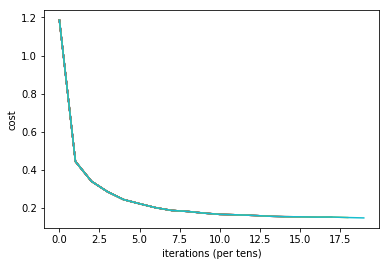

Keep prob:  0.4
Train accuracy: 0.994974
Test accuracy:  0.977143
-----------------------------------------------


In [12]:
parameters, train_accuracy, test_accuracy = model(X_train, y_train, num_epochs=100, k_prob=0.4, print_cost=True)